In [3]:
import pandas as pd
import xarray as xr
import datetime
import numpy as np
import os
import dateutil.parser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
path = "/home/b/b381992/OBSCabauw/"
filelist = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) and "CSV" in os.path.join(path,f)]
filelist.sort()


In [5]:
dfs = []
for filepath in filelist:
    raw_data = pd.read_csv(filepath, skiprows=1)
    height = "79"
    col = f"Horizontal Wind Speed (m/s) at {height}m"
    time_data = raw_data["Time and Date"]#[:-1]
    wind_data = np.array(raw_data[col])#[:-1]
    types = [isinstance(wd,str) for wd in wind_data]
    wind_data[np.where(types)] = np.nan
    wind_data[np.where(wind_data>1000)]=np.nan
    fmt="%d/%m/%Y %H:%M:%S"
    
    time_array = np.array([datetime.datetime.strptime(dateutil.parser.parse(time_data[0]).strftime(fmt), fmt) for single_time_data in time_data])
    dfs.append(xr.Dataset({f"w{height}m": ("time", wind_data), "time": time_array}).astype("float"))



/tmp/ipykernel_1350061/450891003.py:10: RuntimeWarning: invalid value encountered in greater
  wind_data[np.where(wind_data>1000)]=np.nan
/tmp/ipykernel_1350061/450891003.py:10: RuntimeWarning: invalid value encountered in greater
  wind_data[np.where(wind_data>1000)]=np.nan


In [6]:
df=xr.concat(dfs,dim="time")

In [7]:
df.max()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    w79m     float64 24.48

<xarray.Dataset>
Dimensions:  ()
Data variables:
    w79m     float64 24.48

Text(0.5, 1.0, 'Wind at 79m - City: Cabauw')

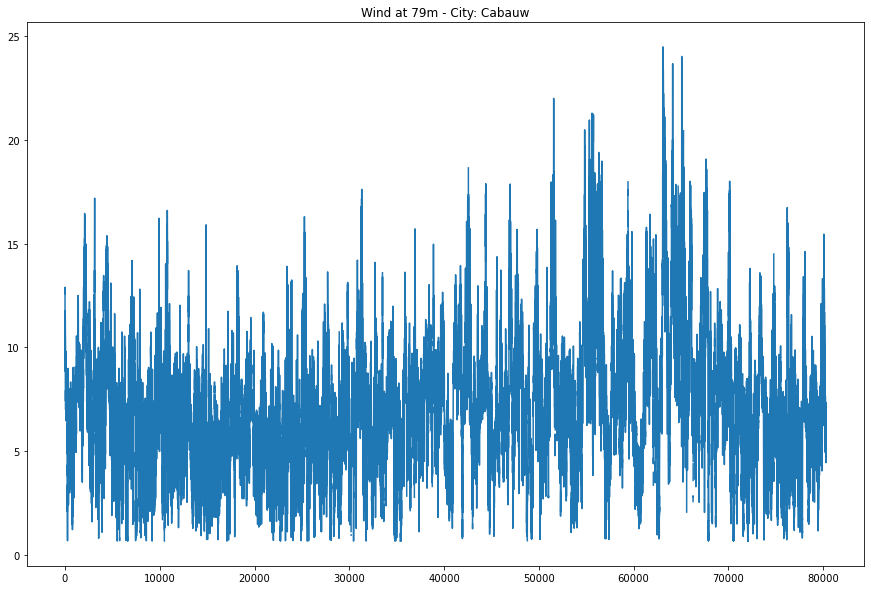

In [7]:
## Select and plot sw rad at surface for first 10 days of august
plt.figure(figsize = (15,10))
plt.plot(np.arange(len(df.time)),df[f"w{height}m"])
plt.title(f'Wind at {height}m - City: Cabauw')
#plt.savefig('../obs.png')

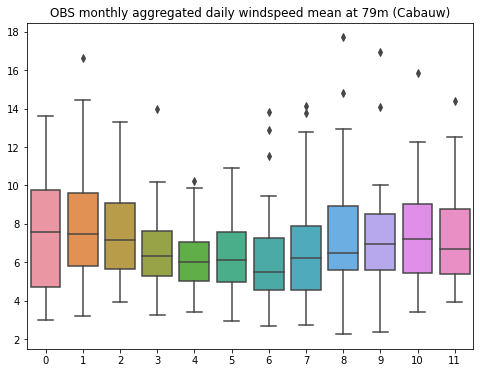

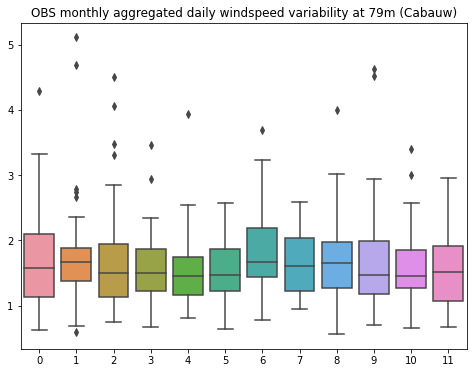

In [70]:
from validation_plots import plot_metrics
plot_metrics(df, f"w{height}m", height, "OBS")

In [9]:
daily_mean=df.groupby("time.date").mean(dim='time')
daily_std=df.groupby("time.date").std(dim='time')
#daily_std=df.resample(time="1D").std(dim='time')

In [36]:
daily_std["date"]=pd.to_datetime(daily_std.date)
daily_mean["date"]=pd.to_datetime(daily_mean.date)

In [44]:
import seaborn as sns

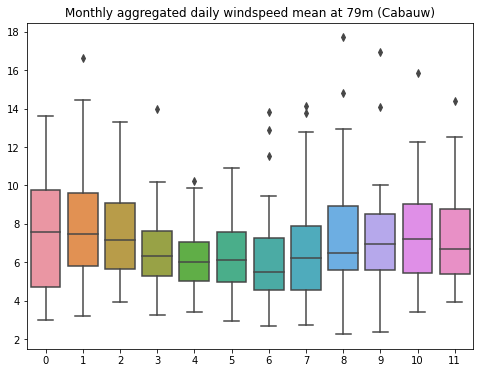

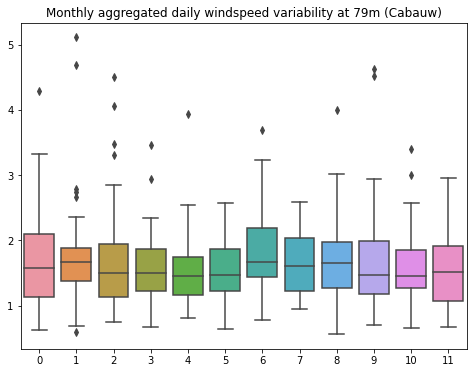

In [47]:
#daily_std.sel(daily_std.groupby("date.month")==1)
for m_name, metric in zip(["mean", "variability"],[daily_mean, daily_std]):
#for m_name, metric in zip(["variability"],[daily_std]):
    month_idxs = metric.groupby('date.month').groups
    list_of_metrics = [metric.isel(date=idxs)[f"w{height}m"] for idxs in month_idxs.values()]
    plt.figure(figsize=(8,6))
    sns.boxplot(data=list_of_metrics)
    plt.title(f"Monthly aggregated daily windspeed {m_name} at {height}m (Cabauw)")